<a href="https://colab.research.google.com/github/BuczynskiRafal/ML/blob/main/supervised/02_regression/04_backward_elimination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import bibliotek

# Nowa sekcja

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

sns.set()
np.random.seed(42)
np.set_printoptions(precision=4, suppress=True)
sklearn.__version__

'1.0.2'

Wczytywanie danych

In [2]:
df_raw = pd.read_csv('https://storage.googleapis.com/esmartdata-courses-files/ml-course/insurance.csv')
df_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Utworzenie kopii danych 

In [3]:
df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Eksploracja i wstępne przygotowanie danych 

Sprawdzenie czy nie ma duplikatów

In [4]:
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [5]:
df[df.charges == 1639.5631]
df[df['charges'] == 1639.5631]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [6]:
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


konwersja danych typu object na dane kategoryczne

In [7]:
cat_cols = [col for col in df.columns if df[col].dtype == 'O']
cat_cols

['sex', 'smoker', 'region']

iterowanie po każdej kolumnie object i zamiana na typ category

In [8]:
for column in cat_cols:
  df[column] = df[column].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


Wyświetlenie podstawowych statystyk

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


Informacje na temat danych kategorycznych

In [10]:
df.describe(include=['category']).T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


SPrawdzenie czy nie ma braków danyc 

In [11]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Sprawdzenie rozkładu zmiennej płeć

In [12]:
df.sex.value_counts()

male      676
female    662
Name: sex, dtype: int64

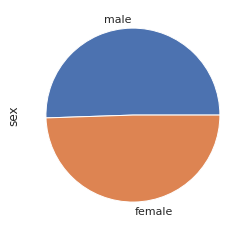

In [13]:
df.sex.value_counts().plot(kind='pie')

In [14]:
df.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

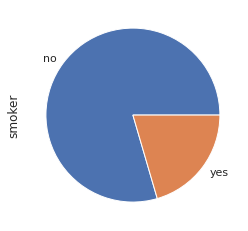

In [15]:
df.smoker.value_counts().plot(kind='pie')

In [16]:
df.region.value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

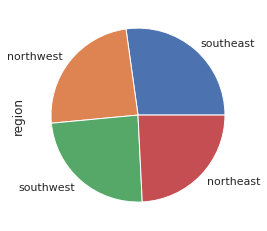

In [17]:
df.region.value_counts().plot(kind='pie')

In [18]:
df.charges.value_counts()

1639.56310     2
16884.92400    1
29330.98315    1
2221.56445     1
19798.05455    1
              ..
7345.08400     1
26109.32905    1
28287.89766    1
1149.39590     1
29141.36030    1
Name: charges, Length: 1337, dtype: int64

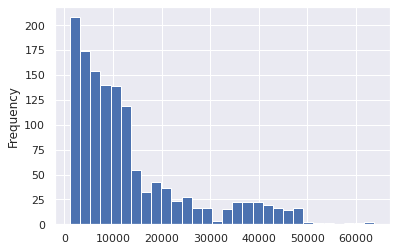

In [19]:
df.charges.plot(kind='hist', bins=30)

wykres pokazujący opłaty w zależności czy osoba pali oraz od płci

In [20]:
import plotly.express as px

px.histogram(df, x='charges', width=700, height=600, nbins=50, facet_col='smoker', facet_row='sex')

Histogram z podziałem na płeć

In [21]:
px.histogram(df, x='smoker', facet_col='sex', color='sex', width=700, height=500)

Przygotowanie danych do modelu

In [22]:
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,1,0,0
1334,18,31.920,0,2205.98080,0,0,0,0,0
1335,18,36.850,0,1629.83350,0,0,0,1,0
1336,21,25.800,0,2007.94500,0,0,0,0,1


Zbadanie korelacji poszczególnych zmiennych

In [23]:
corr = df_dummies.corr()
corr

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.109272,0.042469,0.299008,-0.020856,-0.025019,-0.000407,-0.011642,0.010016
bmi,0.109272,1.000000,0.012759,0.198341,0.046371,0.003750,-0.135996,0.270025,-0.006205
children,0.042469,0.012759,1.000000,0.067998,0.017163,0.007673,0.024806,-0.023066,0.021914
charges,0.299008,0.198341,0.067998,1.000000,0.057292,0.787251,-0.039905,0.073982,-0.043210
sex_male,-0.020856,0.046371,0.017163,0.057292,1.000000,0.076185,-0.011156,0.017117,-0.004184
smoker_yes,-0.025019,0.003750,0.007673,0.787251,0.076185,1.000000,-0.036945,0.068498,-0.036945
region_northwest,-0.000407,-0.135996,0.024806,-0.039905,-0.011156,-0.036945,1.000000,-0.346265,-0.320829
region_southeast,-0.011642,0.270025,-0.023066,0.073982,0.017117,0.068498,-0.346265,1.000000,-0.346265
region_southwest,0.010016,-0.006205,0.021914,-0.043210,-0.004184,-0.036945,-0.320829,-0.346265,1.000000


to samo tylko wyświetlone za pomocą heat mapy

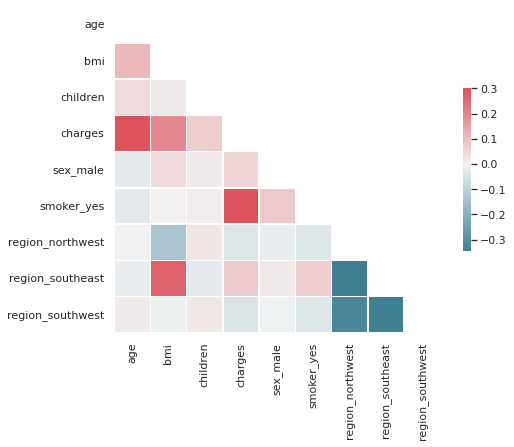

In [24]:
from pandas.core.arrays.numeric import T
from pandas.io.formats import style
sns.set(style='white')
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={'shrink':.5})

Sortowanie aby lepiej zobrazować korelacje

In [25]:
df_dummies.corr()['charges'].sort_values(ascending=False)

charges             1.000000
smoker_yes          0.787251
age                 0.299008
bmi                 0.198341
region_southeast    0.073982
children            0.067998
sex_male            0.057292
region_northwest   -0.039905
region_southwest   -0.043210
Name: charges, dtype: float64

Wykres danych powyżej

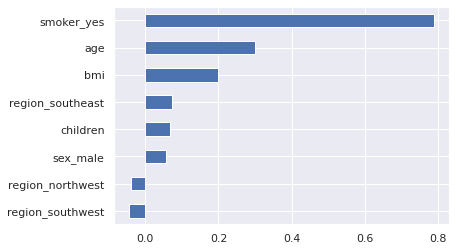

In [26]:
sns.set()
df_dummies.corr()['charges'].sort_values()[:-1].plot(kind='barh')

Przygotownaie danych do uczenia maszynowego


In [27]:
data = df_dummies.copy()
target = data.pop('charges')
data.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,0,1,0,0,1
1,18,33.770,1,1,0,0,1,0
2,28,33.000,3,1,0,0,1,0
3,33,22.705,0,1,0,1,0,0
4,32,28.880,0,1,0,1,0,0


In [28]:
target.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

Podzial na zbior treningowy i testowy

In [29]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)

print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (1070, 8)
x_test shape: (268, 8)
y_train shape: (1070,)
y_test shape: (268,)


Buduję model regresji liniowej

In [30]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression()

Wskaźnik R2 score aby zobaczyć jak model dziala

In [31]:
print(f'R2 score: {regressor.score(x_test, y_test):.4f}')

R2 score: 0.7836


wstępna predykcja, 10 pierwszych elementow któremodel przewidział

In [32]:
y_pred = regressor.predict(x_test)
y_pred[:10]

array([ 8969.5503,  7068.7474, 36858.4109,  9454.6785, 26973.1735,
       10864.1132,   170.2808, 16903.4503,  1092.4309, 11218.3432])

Budowanie ramki danych zawierajacych wartości y_true, y_pred, policzny błąd predykcji i wyświetlone pierwsze 5 wierszy

In [33]:
y_true = y_test.copy()
predictions = pd.DataFrame(data={'y_true': y_true, 'y_pred': y_pred})
predictions['error'] = predictions['y_true'] - predictions['y_pred']
predictions.head()

,y_true,y_pred,error
764,9095.06825,8969.550274,125.517976
887,5272.17580,7068.747443,-1796.571643
890,29330.98315,36858.410912,-7527.427762
1293,9301.89355,9454.678501,-152.784951
259,33750.29180,26973.173457,6777.118343


Histogram blędu

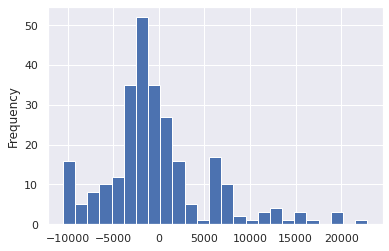

In [34]:
predictions.error.plot(kind='hist', bins= 25)

Można posłużyć się inną metryką niz R2 score na przykład mean_absolyte_error (MAE), lub mean_square_erroe

In [35]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae:.2f}')

MAE: 4181.19


Jak wyglądają współczynniki ktorych model się nauczył

intercept_ jets to punkt przecięcia z osią y

In [36]:
regressor.intercept_

-11931.21905032667

coef_

In [37]:
regressor.coef_

array([  256.9757,   337.0926,   425.2788,   -18.5917, 23651.1289,
        -370.6773,  -657.8643,  -809.7994])

In [38]:
data.columns

Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

# Dobór cech modelu - eliminaja wsteczna

Nie wszytskie kolumny jest rozsądnie wrzucać do modelu dlatego można dokonac eliminacji wstecznej

In [39]:
import statsmodels.api as sm

x_train_ols = x_train.copy()
x_train_ols = x_train_ols.values
x_train_ols = sm.add_constant(x_train_ols)
x_train_ols

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



array([[ 1.   , 46.   , 19.95 , ...,  1.   ,  0.   ,  0.   ],
       [ 1.   , 47.   , 24.32 , ...,  0.   ,  0.   ,  0.   ],
       [ 1.   , 52.   , 24.86 , ...,  0.   ,  1.   ,  0.   ],
       ...,
       [ 1.   , 58.   , 25.175, ...,  0.   ,  0.   ,  0.   ],
       [ 1.   , 37.   , 47.6  , ...,  0.   ,  0.   ,  1.   ],
       [ 1.   , 55.   , 29.9  , ...,  0.   ,  0.   ,  1.   ]])

ols jest regresją liniową w bibliotece statsmodels


---

im P>|t|  jest niższe tym kolumna jets bardziej istotna dla modelu



In [40]:
ols = sm.OLS(endog=y_train, exog=x_train_ols).fit()
predictors = ['const'] + list(x_train.columns)
print(ols.summary(xname=predictors))
print(predictors)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     380.9
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          1.32e-305
Time:                        03:45:38   Log-Likelihood:                -10845.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1061   BIC:                         2.175e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.193e+04   1114.505  

Ponownie dopasowuję model na tak ograniczonych danych

In [41]:
x_selected = x_train_ols[:, [0, 1, 2, 3, 5, 6, 7, 8]]
predictors.remove('sex_male')


ols = sm.OLS(endog=y_train, exog=x_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     435.7
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          6.12e-307
Time:                        03:45:38   Log-Likelihood:                -10845.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1062   BIC:                         2.175e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04   1101.142  

In [42]:
x_selected = x_train_ols[:, [0, 1, 2, 3, 5, 6, 7]]
predictors.remove('region_northwest')


ols = sm.OLS(endog=y_train, exog=x_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     507.3
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          8.16e-308
Time:                        03:45:39   Log-Likelihood:                -10847.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1063   BIC:                         2.174e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.219e+04   1089.230  

In [43]:
x_selected = x_train_ols[:, [0, 1, 2, 3, 5, 6]]
predictors.remove('region_southeast')


ols = sm.OLS(endog=y_train, exog=x_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     609.1
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          3.60e-309
Time:                        03:45:39   Log-Likelihood:                -10847.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1064   BIC:                         2.174e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.217e+04   1087.774  

In [44]:
x_selected = x_train_ols[:, [0, 1, 2, 3, 5]]
predictors.remove('region_southwest')


ols = sm.OLS(endog=y_train, exog=x_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     762.1
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          1.26e-310
Time:                        03:45:39   Log-Likelihood:                -10847.
No. Observations:                1070   AIC:                         2.170e+04
Df Residuals:                    1065   BIC:                         2.173e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.212e+04   1068.509    -11.340      0.0

# Eliminacja wsteczna - automatyzacja

In [48]:
# zmienna z warościami numpy array
x_train_numpy = x_train.values

# dodaję jedynkę na początek
x_train_numpy = sm.add_constant(x_train_numpy)

# liczba zmiennych
num_vars = len(x_train.columns)

# do zmiennej predictors dodaję nazwę pierwszej zmiennej czyli 'const'
predictors = ['const'] + list(x_train.columns)

# poziom istotności statystycznej naszej zmiennej 
sl = 0.05

# iteruję tyle ile mam zmiennych w modelu
for i in range(0, num_vars):
  # w karzdej iteracji tworzę model regresji liniowej w oparciu o nasze dane
  # w pierwszym przelocie wrzucam wszystkie dane x_train_numpy i dopasowuję
  ols = sm.OLS(endog=y_train, exog=x_train_numpy).fit()

  # wyciągam maksymalną wartość
  max_pval = max(ols.pvalues.astype('float'))

  # sprawdzam czy ta wartość jest większa od poziomu istotności 
  if max_pval > sl:
      
      # jeżeli tak to chcę usunać tę zmienną
      for j in range(0, num_vars - i):
          if ols.pvalues[j].astype('float') == max_pval:
              x_train_numpy = np.delete(x_train_numpy, j, axis=1)
              predictors.remove(predictors[j])
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     610.0
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          2.12e-309
Time:                        04:14:29   Log-Likelihood:                -10846.
No. Observations:                1070   AIC:                         2.170e+04
Df Residuals:                    1064   BIC:                         2.173e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.202e+04   1072.501  

# Zapisanie końcowego modelu

In [49]:
ols.save('model.piclke')